In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 

from scipy import stats
import numpy as np 

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


import tensorflow as tf 



 # Data Selection
Import Dataset

In [3]:
charity_df = pd.read_csv('./Resource/charity_data.csv')
charity_df.head()


,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [4]:
charity_df.isnull().sum()    # no null values in entire dataframe
charity_df.dtypes


EIN                        int64
NAME                      object
APPLICATION_TYPE          object
AFFILIATION               object
CLASSIFICATION            object
USE_CASE                  object
ORGANIZATION              object
STATUS                     int64
INCOME_AMT                object
SPECIAL_CONSIDERATIONS    object
ASK_AMT                    int64
IS_SUCCESSFUL              int64
dtype: object

In [5]:
# remove inactivity companies (status is 0)
charity_df = charity_df[charity_df.STATUS == 1]

In [6]:
# store the names of companies in a new dataframe
companies_name_df = charity_df[['EIN','NAME']]
companies_name_df.head()


,EIN,NAME
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT


In [7]:
# remove some irrelevant variables, neither features nor taget for model
charity_df = charity_df.drop(columns = ['EIN','NAME', 'STATUS','SPECIAL_CONSIDERATIONS'])
charity_df.head(3)



,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,0,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1-9999,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,0,5000,0


 # Data Preprocess PART 1
 Transform categorical variables into numerical values

In [8]:
# Generate a name list of categorical variables 
cat_name_list = charity_df.dtypes[charity_df.dtypes == 'object'].index.tolist()
# check the unique values in each columns for bucketing (APPLICATION_TYPE has 17, CLASSIFICATION: 71)
charity_df[cat_name_list].nunique()


APPLICATION_TYPE    17
AFFILIATION          6
CLASSIFICATION      71
USE_CASE             5
ORGANIZATION         4
INCOME_AMT           9
dtype: int64

In [9]:
# check unique values detail and density for APPLICATION_TYPE column
APPL_column_Series = charity_df['APPLICATION_TYPE'].value_counts()
APPL_column_Series

T3     27032
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T14        3
T25        3
T15        2
T29        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

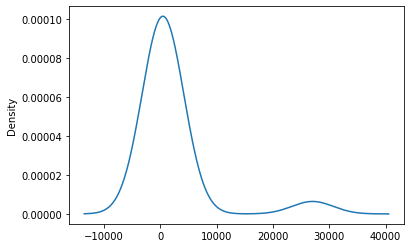

In [10]:
APPL_column_Series.plot.density()


In [11]:
# The cutoff point should be around 200 counts, btw T10 and T9, bucketing them in 'others' 
# Combine rare categorical values via bucketing.
replace_APPL_list = APPL_column_Series[APPL_column_Series < 200].index.tolist()

for app_type in replace_APPL_list:
    charity_df['APPLICATION_TYPE'] = charity_df['APPLICATION_TYPE'].replace(app_type, 'Others')

charity_df['APPLICATION_TYPE'].value_counts()

T3        27032
T4         1542
T6         1216
T5         1173
T19        1065
T8          737
T7          725
T10         528
Others      276
Name: APPLICATION_TYPE, dtype: int64

In [12]:
# check unique values detail and density for CLASSIFICATION column
CLASS_column_Series = charity_df['CLASSIFICATION'].value_counts()
CLASS_column_Series

C1000    17323
C2000     6073
C1200     4837
C3000     1918
C2100     1882
         ...  
C1570        1
C8210        1
C1732        1
C1728        1
C1370        1
Name: CLASSIFICATION, Length: 71, dtype: int64

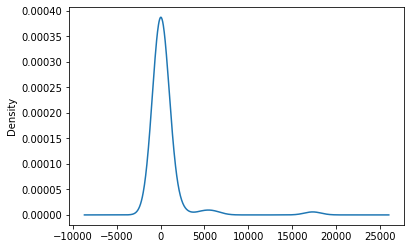

In [13]:
CLASS_column_Series.plot.density()

In [14]:
# The cutoff point should be around 200 counts, btw C4000 and C1700, bucketing them in 'others' 
replace_CLASS_list = CLASS_column_Series[CLASS_column_Series < 200].index.tolist()

for class_type in replace_CLASS_list:
     charity_df['CLASSIFICATION'] = charity_df['CLASSIFICATION'].replace(class_type, 'Others')

charity_df['CLASSIFICATION'].value_counts()


C1000     17323
C2000      6073
C1200      4837
C3000      1918
C2100      1882
Others     1197
C7000       777
C1700       287
Name: CLASSIFICATION, dtype: int64

In [15]:
# double check every categorical variables doesn't exceed 10 unique values
charity_df[cat_name_list].nunique()


APPLICATION_TYPE    9
AFFILIATION         6
CLASSIFICATION      8
USE_CASE            5
ORGANIZATION        4
INCOME_AMT          9
dtype: int64

In [16]:
# use oneHot encode method to convert categorcal variables into several numerical variables
enc = OneHotEncoder(sparse = False) # return array not sparse matrix

# create a encode new DataFrame only contains encoded categorical variables
encode_df = pd.DataFrame(enc.fit_transform(charity_df[cat_name_list]))

encode_df.columns = enc.get_feature_names(input_features = cat_name_list)

encode_df.head()


,APPLICATION_TYPE_Others,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# merge back to orginal df and drop original unencoded columns
encoded_charity_df  = charity_df.merge(encode_df, left_index = True, right_index = True)\
                                .drop(columns = cat_name_list)
encoded_charity_df.head()


,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Others,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


 # Data Selection
 Redece outliers and noisy data points for specific variables

In [18]:
# focus on numerical variable: ASK_AMT 
encoded_charity_df.ASK_AMT.describe()


count    3.428900e+04
mean     2.768940e+06
std      8.714296e+07
min      5.000000e+03
25%      5.000000e+03
50%      5.000000e+03
75%      7.746000e+03
max      8.597806e+09
Name: ASK_AMT, dtype: float64

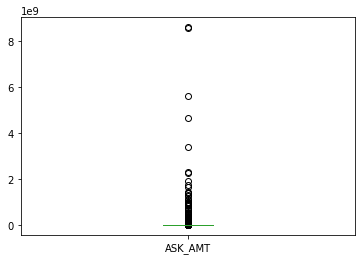

In [19]:
encoded_charity_df.ASK_AMT.plot.box()

In [20]:
# According to boxplot, IQR medthod for outliers has huge outliers(8205), it's not good for this case

Q1 = encoded_charity_df.ASK_AMT.quantile(0.25)
Q3 = encoded_charity_df.ASK_AMT.quantile(0.75)
IQR = Q3 - Q1

boo_ASK = (encoded_charity_df.ASK_AMT < (Q1 - 1.5 * IQR)) |(encoded_charity_df.ASK_AMT > (Q3 + 1.5 * IQR))
IQR_outliers = encoded_charity_df.ASK_AMT[boo_ASK == True]
len(IQR_outliers)


8205

In [21]:
# perform z-score to filter outliers

ASK_AMT_Zscore = np.abs(stats.zscore(charity_df.ASK_AMT) <= 3)

outliers = ASK_AMT_Zscore[ASK_AMT_Zscore == False]

len(outliers)

53

In [22]:
# remove 53 outliers from dataframe
encoded_charity_df = encoded_charity_df[(np.abs(stats.zscore(encoded_charity_df.ASK_AMT)) <= 3)]
encoded_charity_df.head()


,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Others,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:
encoded_charity_df.describe()

,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Others,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
count,3.423600e+04,34236.000000,34236.000000,34236.000000,34236.000000,34236.000000,34236.000000,34236.000000,34236.000000,34236.000000,...,34236.000000,34236.000000,34236.000000,34236.000000,34236.000000,34236.000000,34236.000000,34236.000000,34236.000000,34236.000000
mean,6.819757e+05,0.532773,0.007974,0.015393,0.031108,0.788468,0.044865,0.034175,0.035460,0.021147,...,0.685945,0.711415,0.021264,0.015831,0.098288,0.006952,0.027807,0.109183,0.003856,0.005404
std,7.954197e+06,0.498932,0.088942,0.123112,0.173611,0.408400,0.207011,0.181680,0.184941,0.143877,...,0.464145,0.453111,0.144266,0.124824,0.297708,0.083088,0.164422,0.311874,0.061974,0.073312
min,5.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000e+03,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000e+03,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.257750e+03,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.611646e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


 # Data Preprocess PART 2
 Determine features (X) and target column (y) and split into training, testing data

In [24]:
y = encoded_charity_df['IS_SUCCESSFUL'].values

X = encoded_charity_df.drop(columns = ['IS_SUCCESSFUL']).values

# split into training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


 # Data Preprocess PART 3
 Standardize all features variable before enter into model

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


 # (Removed) Data Preprocess PART 4 PCA:  no improvement for optimazation

In [26]:
#from sklearn.decomposition import PCA

#pca = PCA(n_components = 3, random_state= 42)
# train pca model with scaled data
#pca.fit(X_train_scaled)
# X_pca_train = pca.transform(X_train_scaled)
#X_pca_test =pca.transform(X_test_scaled)
#print(f'The pca ratio is {pca.explained_variance_ratio_}')



 # Deep_Learning Neural Network
 Use TensorFlow neural network design a binary classification model that can predict if
 a previously funded organization will be successful based on the features in the dataset.

In [27]:
# determine number of neurons in each layers
num_input = len(X_train_scaled[0])
num_first = len(X_train_scaled[0])*2
num_second = 50
num_third = 20

#kernel_reg = tf.keras.regularizers.l2(0.01)
#act_reg = tf.keras.regularizers.l1(0.01)

# build a Sequential model as a base
nn_model = tf.keras.models.Sequential()

# build Dense layer for input and first hidden layer
nn_model.add(tf.keras.layers.Dense(units=num_first, input_dim = num_input,
                                    activation ='relu'))
                                    #kernel_regularizer = kernel_reg,activity_regularizer= act_reg))
# seconde hidden layer
nn_model.add(tf.keras.layers.Dense(units = num_second, activation='relu'))
# THIRD hidden layer
nn_model.add(tf.keras.layers.Dense(units = num_third, activation='relu'))
# now add a ReLU layer explicitly:
#nn_model.add(tf.keras.layers.LeakyReLU(alpha=0.05))
# output layer
nn_model.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))

nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 84)                3612      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                4250      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 8,903
Trainable params: 8,903
Non-trainable params: 0
_________________________________________________________________


In [28]:
# config setting
nn_model.compile(loss = 'binary_crossentropy', optimizer = 'adam',
                metrics = ['accuracy'])

Train on 25677 samples
Epoch 1/200
25677/25677 [==============================] - 1s 52us/sample - loss: 0.6475 - accuracy: 0.6037
Epoch 2/200
25677/25677 [==============================] - 1s 58us/sample - loss: 0.6481 - accuracy: 0.6026
Epoch 3/200
25677/25677 [==============================] - 1s 47us/sample - loss: 0.6472 - accuracy: 0.6034
Epoch 4/200
25677/25677 [==============================] - 1s 50us/sample - loss: 0.6473 - accuracy: 0.6035
Epoch 5/200
25677/25677 [==============================] - 1s 50us/sample - loss: 0.6486 - accuracy: 0.6028
Epoch 6/200
25677/25677 [==============================] - 1s 48us/sample - loss: 0.6474 - accuracy: 0.6036
Epoch 7/200
25677/25677 [==============================] - 1s 47us/sample - loss: 0.6482 - accuracy: 0.6023
Epoch 8/200
25677/25677 [==============================] - 1s 48us/sample - loss: 0.6471 - accuracy: 0.6033
Epoch 9/200
25677/25677 [==============================] - 1s 48us/sample - loss: 0.6470 - accuracy: 0.6032
Epoch

25677/25677 [==============================] - 1s 46us/sample - loss: 0.6472 - accuracy: 0.6034
Epoch 77/200
25677/25677 [==============================] - 1s 50us/sample - loss: 0.6463 - accuracy: 0.6041
Epoch 78/200
25677/25677 [==============================] - 1s 51us/sample - loss: 0.6479 - accuracy: 0.6032
Epoch 79/200
25677/25677 [==============================] - 1s 47us/sample - loss: 0.6487 - accuracy: 0.6037
Epoch 80/200
25677/25677 [==============================] - 1s 45us/sample - loss: 0.6464 - accuracy: 0.6033
Epoch 81/200
25677/25677 [==============================] - 1s 49us/sample - loss: 0.6467 - accuracy: 0.6031
Epoch 82/200
25677/25677 [==============================] - 1s 48us/sample - loss: 0.6466 - accuracy: 0.6018
Epoch 83/200
25677/25677 [==============================] - 1s 48us/sample - loss: 0.6496 - accuracy: 0.6035
Epoch 84/200
25677/25677 [==============================] - 1s 46us/sample - loss: 0.6467 - accuracy: 0.6044
Epoch 85/200
25677/25677 [======

25677/25677 [==============================] - 1s 51us/sample - loss: 0.6457 - accuracy: 0.6049
Epoch 151/200
25677/25677 [==============================] - 1s 47us/sample - loss: 0.6463 - accuracy: 0.6040
Epoch 152/200
25677/25677 [==============================] - 1s 48us/sample - loss: 0.6465 - accuracy: 0.6041
Epoch 153/200
25677/25677 [==============================] - 1s 47us/sample - loss: 0.6459 - accuracy: 0.6035
Epoch 154/200
25677/25677 [==============================] - 1s 51us/sample - loss: 0.6462 - accuracy: 0.6035
Epoch 155/200
25677/25677 [==============================] - 1s 50us/sample - loss: 0.6478 - accuracy: 0.6041
Epoch 156/200
25677/25677 [==============================] - 1s 51us/sample - loss: 0.6495 - accuracy: 0.6040
Epoch 157/200
25677/25677 [==============================] - 1s 48us/sample - loss: 0.6454 - accuracy: 0.6057
Epoch 158/200
25677/25677 [==============================] - 1s 48us/sample - loss: 0.6450 - accuracy: 0.6060
Epoch 159/200
25677/2567

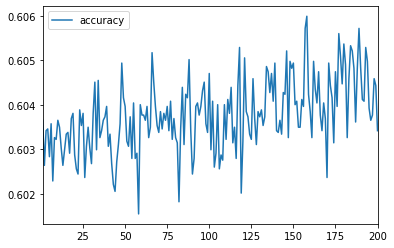

In [33]:
# train model with training data
model_history = nn_model.fit(X_train_scaled, y_train, epochs=200)

history_df = pd.DataFrame(model_history.history, 
                    index = range(1, len(model_history.history['loss'])+1))

# viz the loss 
history_df.plot(y = 'accuracy')

In [30]:
# evaluate with test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled, y_test,
                                                verbose = 2)
print(f"The model's Loss is {model_loss}, Accuracy is {model_accuracy}")



8559/8559 - 0s - loss: 0.8240 - accuracy: 0.5732
The model's Loss is 0.8239545298731346, Accuracy is 0.5731977820396423
